# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [6]:
!pip -q install ./python

In [7]:
!pip install unityagents

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [8]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [9]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state, sep="\n")
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like:
[ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [11]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    np.set_printoptions(precision=2)
    if reward != 0:
        print("Action {}, Reward {}, \nState change \n{}, \nLast state \n{}".format(
            action, reward, next_state - state, state))
    state = next_state                             # roll over the state to next time step        
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


# Create or load agent

In [12]:
import torch
from dqn_agent import Agent
checkpoint_name = "checkpoint.pth"

agent = Agent(state_size=37, action_size=4, seed=0)
# load the weights from file
#agent.qnetwork_local.load_state_dict(torch.load(checkpoint_name))
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]  

In [16]:
from collections import deque
def dqn(n_episodes=500, max_t=300, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    rewards_window = deque(maxlen=1000)# This is for debug and lets one get a better idea of optimality
    actions_window = deque(maxlen=1000)# This is to track what actions are happening 
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]  
        score = 0
        #print("Episode ", i_episode)
        for t in range(max_t):
            action = agent.act(state, eps)
            actions_window.append(action)
            #print("action ", action)
            env_info = env.step(action)[brain_name]
            #print('env_info', str(env_info))
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            rewards_window.append(int(reward))
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                # Done happens at t=299
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.4f}'.format(i_episode, np.mean(scores_window), eps), end="")
        if i_episode % 20 == 0:
            #print("rewards_window ", rewards_window)
            #print("Rewards_window + 1 ", np.add(rewards_window, 1))
            #print(" bincounts ", np.bincount(np.add(rewards_window,1)))
            # Append 0's in case only negative -1s were seen
            rewards_bc = np.append(np.bincount(np.add(rewards_window, 1)),[0,0])
            forward_count_percent = np.bincount(actions_window)[0]/1000.0
            print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.4f}\tBlues:{}\tNone:{}\tYellows:{}\tforward frames:{}'
                  .format(i_episode, np.mean(scores_window), eps, rewards_bc[0],rewards_bc[1], rewards_bc[2], forward_count_percent))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

In [17]:
scores = dqn(1000, 300, 1.0, eps_decay=.995)

Episode 20	Average Score: 0.40	eps: 0.9046	Blues:2	None:996	Yellows:2	forward frames:0.28
Episode 40	Average Score: 0.38	eps: 0.8183	Blues:2	None:998	Yellows:0	forward frames:0.248
Episode 60	Average Score: 0.75	eps: 0.7403	Blues:1	None:989	Yellows:10	forward frames:0.283
Episode 80	Average Score: 1.21	eps: 0.6696	Blues:0	None:994	Yellows:6	forward frames:0.261
Episode 100	Average Score: 1.66	eps: 0.6058	Blues:1	None:984	Yellows:15	forward frames:0.306
Episode 120	Average Score: 2.46	eps: 0.5480	Blues:2	None:975	Yellows:23	forward frames:0.331
Episode 140	Average Score: 3.12	eps: 0.4957	Blues:1	None:991	Yellows:8	forward frames:0.256
Episode 160	Average Score: 4.01	eps: 0.4484	Blues:3	None:969	Yellows:28	forward frames:0.306
Episode 180	Average Score: 4.92	eps: 0.4057	Blues:1	None:977	Yellows:22	forward frames:0.413
Episode 200	Average Score: 5.65	eps: 0.3670	Blues:0	None:981	Yellows:19	forward frames:0.32
Episode 220	Average Score: 6.61	eps: 0.3320	Blues:1	None:962	Yellows:37	forward 

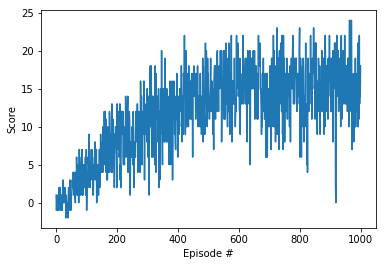

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()